In [1]:
import numpy as np
import pandas as pd
import urllib.request as requests
import string
import re
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('dataset.csv')
data

,sentiment,comment
0,5,Chất lượng sản phẩm:tốt Đúng với mô tả:đẹp Hà...
1,5,Với giá thành này thì hàng khá ổn . Bị lỗi pin...
2,5,Tính năng nổi bật:máy sáng Đúng với mô tả:chuẩ...
3,4,"Máy đã thay vỏ nên ngoại hình đẹp, dùng làm má..."
4,5,Chất lượng sản phẩm:sản phẩm dùng ổn định Máy...
...,...,...
2519,1,Chx nhận đc hàng
2520,3,Đặt pin xanh giao pin màu xám
2521,2,Shop ghi pin mới 100% nhưng không phải đây là ...
2522,5,Rất tốt


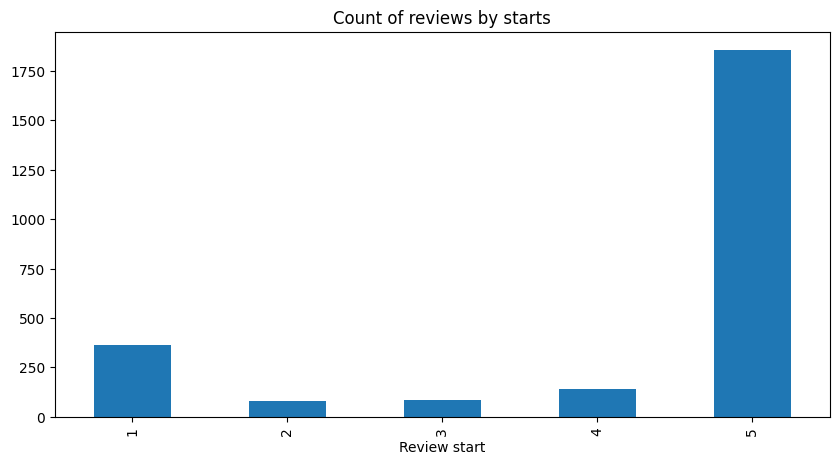

In [3]:
ax = data['sentiment'].value_counts().sort_index().plot(kind='bar', 
                                                        title='Count of reviews by starts',
                                                        figsize=(10,5))
ax.set_xlabel('Review start')
plt.show()

Pre Processing

In [4]:
stop_words = []
with open('vietnamese-stopwords.txt', encoding='utf-8') as f:
    stop_words = [t for t in f.read().split('\n')]

In [5]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smile_emoji        = r"[8:=;]['`\-]?[)d]+"
sad_emoji          = r"[8:=;]['`\-]?\(+"
neutral_emoji      = r"[8:=;]['`\-]?[\/|l*]"
lol_emoji          = r"[8:=;]['`\-]?p+"

def preprocess(input:str):
    # Lower
    input = input.lower()
    # clean
    input = input.strip().replace('\n', '')

    # Replace 3 or more consecutive letters by 2 letter.
    input = re.sub(sequencePattern, seqReplacePattern, input)
    
    # Replace all emojis.
    input = re.sub(r'<3', 'tim', input)
    input = re.sub(smile_emoji, 'cười', input)
    input = re.sub(sad_emoji, 'buồn', input)
    input = re.sub(neutral_emoji, 'bình thường', input)
    input = re.sub(lol_emoji, 'vui', input)
    
    # Keep word
    input = re.sub('\[.*?\]', ' ', input)
    input = re.sub('https?://\S+|www\.\S+', ' ', input)
    input = re.sub('<.*?>+', ' ', input)
    input = re.sub('[%s]' % re.escape(string.punctuation), ' ', input)
    input = re.sub('\n', ' ', input)
    input = re.sub('\w*\d\w*', ' ', input)
    
    return ' '.join([word for word in input.split() if word not in stop_words])

data.dropna()
data["processed"] = data["comment"].apply(lambda x: preprocess(x))
data.head(10)

,sentiment,comment,processed
0,5,Chất lượng sản phẩm:tốt Đúng với mô tả:đẹp Hà...,chất sản phẩm tốt mô tả đẹp hàng đẹp mua khá m...
1,5,Với giá thành này thì hàng khá ổn . Bị lỗi pin...,giá thành hàng khá ổn lỗi pin shop gửi pin mk ...
2,5,Tính năng nổi bật:máy sáng Đúng với mô tả:chuẩ...,năng nổi bật máy mô tả chuẩn chất sản phẩm hàn...
3,4,"Máy đã thay vỏ nên ngoại hình đẹp, dùng làm má...",máy thay vỏ ngoại hình đẹp máy phụ ổn ngon nút...
4,5,Chất lượng sản phẩm:sản phẩm dùng ổn định Máy...,chất sản phẩm sản phẩm ổn định máy đẹp lỗi gói...
5,5,Rất oke nè giá học sinh sinh viên shop rất uy ...,oke nè giá học sinh sinh viên shop uy tín nhu ...
6,5,Chất lượng sản phẩm:ok mọi thứ tạm ổn so với t...,chất sản phẩm ok tạm ổn tầm giá mô tả
7,1,Mọi người k nên mua nha..shop bán điện thoại q...,k mua nha shop điện thoại tệ vs giá tệ nhân ph...
8,5,Hàng tốt .. đt mới tinh mớii tinh mọi người nê...,hàng tốt đt tinh mớii tinh mua
9,5,Máy ok Ship hàng nhanh,máy ok ship hàng


In [6]:


text = ['sản phẩm tốt', 'ổn', 'k ổn', 'tệ', 'giao sai hàng', 'tạm được', 'ok <3']
y = [preprocess(t) for t in text]
print(y)

['sản phẩm tốt', 'ổn', 'k ổn', 'tệ', 'giao sai hàng', 'tạm', 'ok tim']


In [7]:
def scale(x):
    if x == 5:
        return 1
    return 0
data["sentiment"] = data["sentiment"].apply(lambda x: scale(x))
data.head(10)

,sentiment,comment,processed
0,1,Chất lượng sản phẩm:tốt Đúng với mô tả:đẹp Hà...,chất sản phẩm tốt mô tả đẹp hàng đẹp mua khá m...
1,1,Với giá thành này thì hàng khá ổn . Bị lỗi pin...,giá thành hàng khá ổn lỗi pin shop gửi pin mk ...
2,1,Tính năng nổi bật:máy sáng Đúng với mô tả:chuẩ...,năng nổi bật máy mô tả chuẩn chất sản phẩm hàn...
3,0,"Máy đã thay vỏ nên ngoại hình đẹp, dùng làm má...",máy thay vỏ ngoại hình đẹp máy phụ ổn ngon nút...
4,1,Chất lượng sản phẩm:sản phẩm dùng ổn định Máy...,chất sản phẩm sản phẩm ổn định máy đẹp lỗi gói...
5,1,Rất oke nè giá học sinh sinh viên shop rất uy ...,oke nè giá học sinh sinh viên shop uy tín nhu ...
6,1,Chất lượng sản phẩm:ok mọi thứ tạm ổn so với t...,chất sản phẩm ok tạm ổn tầm giá mô tả
7,0,Mọi người k nên mua nha..shop bán điện thoại q...,k mua nha shop điện thoại tệ vs giá tệ nhân ph...
8,1,Hàng tốt .. đt mới tinh mớii tinh mọi người nê...,hàng tốt đt tinh mớii tinh mua
9,1,Máy ok Ship hàng nhanh,máy ok ship hàng


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten
from sklearn.model_selection import train_test_split


In [9]:
vocab_size = 10000
embedding_dim = 64
max_length = 50

sequences = data.processed
labels = data.sentiment

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(sequences)

In [10]:
X_train, X_test, train_labels, test_labels = train_test_split(sequences, labels, test_size = 0.2, random_state = 42)


In [11]:
train_sequences = tokenizer.texts_to_sequences(X_train)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, truncating='post', padding='post')
padded_train_sequences

array([[ 87, 122,   0, ...,   0,   0,   0],
       [ 14,  10, 123, ...,   0,   0,   0],
       [  6,   2,   3, ...,   0,   0,   0],
       ...,
       [ 25,  27,  28, ...,   0,   0,   0],
       [ 17,  43, 132, ...,   0,   0,   0],
       [  6,   2, 128, ...,   0,   0,   0]])

In [12]:
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, truncating='post', padding='post')
padded_test_sequences.shape

(505, 50)

Model

In [13]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Bidirectional
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import plotly.express as px


In [14]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            640000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,234,453
Trainable params: 1,234,453
Non-

In [15]:
history = model.fit(padded_train_sequences, train_labels, epochs=10, validation_data=(padded_test_sequences, test_labels))

Epoch 1/10
64/64 [==============================] - 12s 105ms/step - loss: 0.5662 - accuracy: 0.7390 - val_loss: 0.4280 - val_accuracy: 0.8198
Epoch 2/10
64/64 [==============================] - 5s 85ms/step - loss: 0.3763 - accuracy: 0.8375 - val_loss: 0.4090 - val_accuracy: 0.8198
Epoch 3/10
64/64 [==============================] - 5s 82ms/step - loss: 0.2992 - accuracy: 0.8836 - val_loss: 0.4235 - val_accuracy: 0.8059
Epoch 4/10
64/64 [==============================] - 5s 82ms/step - loss: 0.2587 - accuracy: 0.9059 - val_loss: 0.4931 - val_accuracy: 0.7921
Epoch 5/10
64/64 [==============================] - 5s 84ms/step - loss: 0.2090 - accuracy: 0.9237 - val_loss: 0.4858 - val_accuracy: 0.8099
Epoch 6/10
64/64 [==============================] - 6s 87ms/step - loss: 0.1987 - accuracy: 0.9222 - val_loss: 0.5490 - val_accuracy: 0.7861
Epoch 7/10
64/64 [==============================] - 6s 97ms/step - loss: 0.2254 - accuracy: 0.9158 - val_loss: 0.5532 - val_accuracy: 0.7980
Epoch 8/10


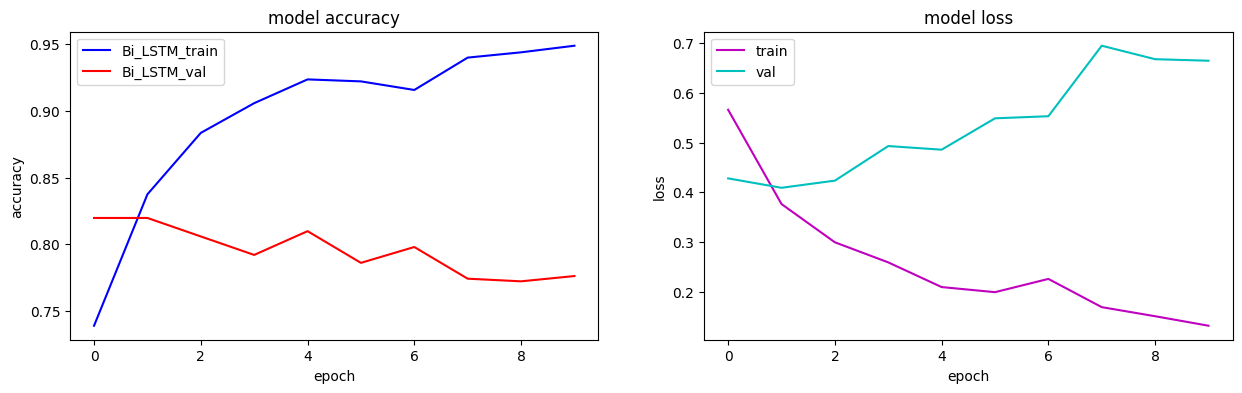

In [16]:
s, (at, al) = plt.subplots(1, 2, figsize=(15,4))
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Bi_LSTM_train', 'Bi_LSTM_val'])

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'])

In [22]:
def my_predict(input:list):
    input = [preprocess(i) for i in input]
    text_tokenizer = tokenizer.texts_to_sequences(pd.Series(input))
    padded_test = pad_sequences(text_tokenizer, maxlen=max_length, truncating='post', padding='post')
    y_predict = model.predict(padded_test)
    for t, pred in zip(input, y_predict):
        print(f'{t} : {sentiment(pred)} ({pred.round(decimals=3)})')

def sentiment(x:int):
    if x > 0.7:
        return 'positive'
    if x > 0.4:
        return 'neutral'
    return 'negative'


TextDisplayObject = ['sản phẩm tốt', 'ổn', 'k ổn', 'tệ', 'giao sai hàng', 'tạm được', 'ok <3', 'áo bị bung chỉ']
y_predict = my_predict(texts)

1/1 [==============================] - 0s 36ms/step
sản phẩm tốt : positive ([0.929])
ổn : neutral ([0.626])
k ổn : negative ([0.376])
tệ : negative ([0.133])
giao sai hàng : negative ([0.127])
tạm : neutral ([0.453])
ok tim : positive ([0.986])
áo bung : negative ([0.133])
